# Versione 31-07

## epsilon decay =0.99

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import json

class TSPEnvironment:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities, depot_positions, distance_matrix, speed=50, max_time=8):
        self.num_nodi = len(facility_positions) + len(client_positions) + len(depot_positions)  # Consideriamo anche le facility come nodi
        self.nodes_positions = facility_positions + client_positions + depot_positions # Aggiungiamo le posizioni delle facility

        self.demands = np.array([0] * len(facility_positions) + demands + [0] * len(depot_positions))  # Aggiungiamo domanda zero per le facility
        self.facility_positions= facility_positions
        self.client_positions= client_positions
        self.depot_positions= depot_positions
        self.vehicle_capacities = np.array(vehicle_capacities)
        self.facility_capacities = np.array(facility_capacities)
        self.speed = speed  # Velocità in km/h
        self.max_time = max_time  # Tempo massimo in ore
        # Pre-calcola le distanze tra i nodi
        self.distance_matrix = distance_matrix.to_numpy()


    def calcola_distanza(self, node1, node2):
        return self.distance_matrix[node1][node2]


    def calcola_tempo(self, distanza_km):
        return distanza_km / self.speed

class QLearningVRP:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities, depot_positions, num_vehicles, distance_matrix, learning_rate=0.2, discount_factor=0.9, initial_epsilon=1.0, epsilon_decay=0.99, random_seed=0):
        np.random.seed(random_seed)
        random.seed(random_seed)
        self.env = TSPEnvironment(client_positions, demands, vehicle_capacities, facility_positions, facility_capacities, depot_positions,distance_matrix)
        self.num_nodi = len(facility_positions) + len(client_positions) + len(depot_positions)
        self.num_vehicles = num_vehicles
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.exploration_rate = initial_epsilon
        self.q_table = {}
        self.visitati = set()
        self.performance_history = []
        self.facility_visitata_dal_veicolo=[False]*num_vehicles

    def get_state_id(self, cammini):
        state_id = hash(tuple((idx, tuple(cammino)) for idx, cammino in enumerate(cammini))) #anche se i veicoli hanno percorsi uguali, avranno stati diversi.

        if state_id not in self.visitati:
            self.visitati.add(state_id)
            return state_id
        else:
            return None

    def aggiorna_q_table(self, state_id, action, reward, next_state_id):
        if state_id not in self.q_table: # se lo state_id è presente nella Q-table. Se non è presente, lo inizializza come un dizionario vuoto 
            self.q_table[state_id] = {}
        if action not in self.q_table[state_id]:# Verifica se l'action è presente nella Q-table per lo state_id. Se non è presente, inizializza il valore di Q per quell'azione a 0
            self.q_table[state_id][action] = 0

        if next_state_id in self.q_table: #Se next_state_id è presente nella Q-table, calcola td_target come la somma di reward e fattore di sconto moltiplicato per il valore Q dell'azione migliore (best_next_action) nello next_state_id.
            best_next_action = max(self.q_table[next_state_id], key=lambda a: self.q_table[next_state_id][a])
            td_target = reward + self.discount_factor * self.q_table[next_state_id][best_next_action]
        else:
            td_target = reward #Se next_state_id non è presente nella Q-table, imposta td_target uguale alla reward (poiché non c'è informazione sullo stato successivo)

        td_error = td_target - self.q_table[state_id][action] #Calcola l'errore TD come la differenza tra td_target e il valore Q attuale per lo state_id 
        self.q_table[state_id][action] += self.learning_rate * td_error #Aggiorna il valore Q per lo state_id e action utilizzando il learning rate



    def calcola_ricompensa(self, cammini, carico_facilities, domanda_rimanente, log=False):
        # Inizializzazione delle variabili
        tempo_totali = [0] * self.num_vehicles
        carichi = [0] * self.num_vehicles
        distanze_totali = []
    
        # Calcolo del tempo totale e del carico totale per ciascun veicolo
        for idx, cammino in enumerate(cammini):
            for i in range(len(cammino) - 1):
                distanza = self.env.calcola_distanza(cammino[i], cammino[i + 1])
                tempo_totali[idx] += self.env.calcola_tempo(distanza)
                carichi[idx] += self.env.demands[cammino[i + 1]]
                distanze_totali.append(distanza)
    
        # Calcolo della ricompensa basata sul tempo per ogni singolo veicolo
        ricompensa_tempo = 0
        for tempo in tempo_totali:
            ricompensa_veicolo_tempo = -tempo
            if tempo > self.env.max_time:
                ricompensa_veicolo_tempo -= 100 * (tempo - self.env.max_time)
            ricompensa_tempo += ricompensa_veicolo_tempo
    
        # Calcolo della ricompensa basata sul carico per ogni singolo veicolo
        ricompensa_carico = 0
        for carico in carichi:
            ricompensa_veicolo_carico = -carico
            max_vehicle_capacity = np.max(self.env.vehicle_capacities)
            if carico > max_vehicle_capacity:
                ricompensa_veicolo_carico -= 100 * (carico - max_vehicle_capacity)
            ricompensa_carico += ricompensa_veicolo_carico
    
        # Calcolo unfairness
        max_diff = 0
        for i in range(len(distanze_totali)):
            for j in range(i + 1, len(distanze_totali)):
                diff = abs(distanze_totali[i] - distanze_totali[j])
                if diff > max_diff:
                    max_diff = diff
    
        unfairness = -10 * max_diff
    
        # Calcolo della ricompensa basata sui carichi delle strutture per ogni singola facility
        ricompensa_facilities = 0
        for i in range(len(carico_facilities)):
            ricompensa_facility = 0
            if carico_facilities[i] > self.env.facility_capacities[i]:
                ricompensa_facility -= 100 * (carico_facilities[i] - self.env.facility_capacities[i])
            ricompensa_facilities += ricompensa_facility
    
        # Calcolo della ricompensa totale combinando le diverse componenti
        total_reward = (ricompensa_tempo +
                        ricompensa_carico +
                        ricompensa_facilities +
                        unfairness)
    
        # Stampa dei dettagli della ricompensa se log è True
        if log:
            print(f"Reward Componenti:\n"
                  f"Tempo: {ricompensa_tempo}\n"
                  f"Carico: {ricompensa_carico}\n"
                  f"Facilities: {ricompensa_facilities}\n"
                  f"Unfairness: {unfairness}\n"
                  f"Total Reward: {total_reward}\n")
    
        return total_reward



    #ottimizza tra esplorazione e sfruttamento in modo adattivo basandosi sulle performance recenti dell'algoritmo.
    def aggiorna_epsilon_adattivo(self, soglia_performance=0.2):
        if len(self.performance_history) > 10: # Calcola la media delle differenze tra le performance delle ultime 10 iterazioni.
            # miglioramento_medio = np.mean(np.diff(self.performance_history[-10:]))
            # if miglioramento_medio < soglia_performance:
            #     self.exploration_rate = min(self.exploration_rate * 1.01, 1.0)#Se il miglioramento medio è inferiore alla soglia (soglia_performance), aumenta il tasso di esplorazione del 1%.
            # else:
            self.exploration_rate = max(self.exploration_rate * 0.99, 0.00001) #Se il miglioramento medio è maggiore o uguale alla soglia, riduce il tasso di esplorazione del 5% (fino a un minimo di 0.001).




    def addestramento(self, num_episodi):
        global nodo_successivo
        rewards_history = []
        rewards_cumulative = []
        ultimo_cammino = None
        rewards_per_episode = []
        tempi_totali_per_episode = [] 
        depot_positions_indices = list(range(self.num_nodi - len(self.env.depot_positions), self.num_nodi))
        #print(depot_positions_indices)
        
        for episode in range(num_episodi):
            start_nodes = depot_positions_indices   # Lista dei nodi deposito
            cammini = []
            nodi_correnti = []
            domanda_rimanente = self.env.demands.copy()  #per il Tracciamento delle domande rimanenti           
            carico_corrente = [0] * self.num_vehicles
            carico_facilities = [0] * len(self.env.facility_positions)
            total_reward = 0
            facility_visitata_dal_veicolo = [False] * self.num_vehicles #per capire se il veicolo ha già visitato la facility
            vehicle_active = [True] * self.num_vehicles
            nodo_visitato_dal_veicolo = [False] * self.num_vehicles
            clienti_da_visitare = set(range(self.num_nodi -len(self.env.depot_positions)-len(self.env.client_positions),self.num_nodi -len(self.env.depot_positions)))

            # Inizializza i cammini, nodi correnti e assegnazioni dei depositi
            for idx in range(self.num_vehicles):
                start_node = start_nodes[idx % len(start_nodes)]
                cammini.append([start_node])
                nodi_correnti.append(start_node)



            while len(clienti_da_visitare)>=0: 

                nonvisitati = [node for node in range(self.num_nodi) if node not in start_nodes]
                valid_action = False

                for idx, cammino in enumerate(cammini):

                    if len(clienti_da_visitare) == 0:
                        # Solo facilities possono essere scelte se tutti i clienti sono stati visitati
                        facilities_non_visitati = [node for node in nonvisitati if  node < self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions)]
                        facilities_non_visitati_cs = [
                        node for node in facilities_non_visitati 
                        if carico_corrente[idx] <= self.env.facility_capacities[node - (self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))] - carico_facilities[node - (self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))]
                    ]
                        

                        if facilities_non_visitati_cs:# se ci sono facilities (con sufficiente capacità) visitabili allora scegli tra quelle

                            if nodo_visitato_dal_veicolo[idx]:# Controlla se il veicolo ha visitato almeno un nodo cliente dopo il deposito
                                nodo_successivo = np.random.choice(facilities_non_visitati_cs) if np.random.rand() < self.exploration_rate else facilities_non_visitati_cs[np.argmax([self.q_table.get(self.get_state_id([cammino + [action] for cammino in cammini if vehicle_active[idx]]), {}).get(action, 0) for action in facilities_non_visitati_cs])]

                            else:

                                continue  # Se il veicolo ha solo il deposito nel cammino, non scegli nessun nodo_successivo
                        else:#le facilities non hanno le capacità sufficienti allora scegline una che non ha la capacità sufficiente
                            facilities_non_visitati_ns = [node for node in nonvisitati if  node < self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions)]
                            if facilities_non_visitati_ns:
                                # Controlla se il veicolo ha visitato almeno un nodo cliente dopo il deposito
                                if nodo_visitato_dal_veicolo[idx]:
                                    nodo_successivo = np.random.choice(facilities_non_visitati_ns) if np.random.rand() < self.exploration_rate else facilities_non_visitati_ns[np.argmax([self.q_table.get(self.get_state_id([cammino + [action] for cammino in cammini if vehicle_active[idx]]), {}).get(action, 0) for action in facilities_non_visitati_ns])]

                                else:
    
                                    continue  # Se il veicolo ha solo il deposito nel cammino, non scegli nessun nodo_successivo                            
                            
                        # print(f"{len(clienti_da_visitare)},Episode {episode+1}, Vehicle {idx}, Nodo successivo: {nodo_successivo}, Tipo: Facility")                        
                    else: #se ci sono ancora clienti da visitare scegli solo tra i nodi cliente per cui il tempo non superi quello max (8 ore)
                        clienti_non_visitati = [node for node in nonvisitati if node in clienti_da_visitare] 
    
                        # Calcolo del tempo totale attuale per il veicolo
                        tempo_attuale = sum(self.env.calcola_tempo(self.env.calcola_distanza(cammino[i], cammino[i + 1])) for i in range(len(cammino) - 1))
    
                        # Filtra i clienti non visitati in base al tempo massimo consentito
                        clienti_validi = [cliente for cliente in clienti_non_visitati if tempo_attuale + self.env.calcola_tempo(self.env.calcola_distanza(nodi_correnti[idx], cliente)) <= self.env.max_time]
                        
                        if not clienti_validi:
                            continue
                        
                        if np.random.rand() < self.exploration_rate:
                            nodo_successivo = np.random.choice(clienti_validi)
                        else:
                            q_values = [self.q_table.get(self.get_state_id([cammino + [action] for cammino in cammini if vehicle_active[idx]]), {}).get(action, 0) for action in clienti_validi]
                            nodo_successivo = clienti_validi[np.argmax(q_values)]
                           
                        # print(f"{len(clienti_da_visitare)},Episode {episode+1}, Vehicle {idx}, Nodo successivo: {nodo_successivo}, Tipo: Cliente")   
                    
                        
                    if not vehicle_active[idx]:
                        continue


                    if carico_corrente[idx] + domanda_rimanente[nodo_successivo] <= self.env.vehicle_capacities[idx]:
                        #print(carico_corrente[idx] + domanda_rimanente[nodo_successivo] <= self.env.vehicle_capacities[idx])
                        if nodo_successivo < self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions) :  # Facility
                            #print(nodo_successivo)
                            facility_idx = nodo_successivo - (self.num_nodi - len(self.env.client_positions)- len(self.env.depot_positions))
                            
                            if not facility_visitata_dal_veicolo[idx]: # Veicolo non ha ancora visitato una facility e ha visitato almeno un nodo
                                # print(f"facility")
                                #print(f"Veicolo {idx} ha aggiunto la facility {nodo_successivo} al proprio cammino.")
                                facility_visitata_dal_veicolo[idx] = True
                                cammino.append(nodo_successivo)
                                carico_facilities[facility_idx] += carico_corrente[idx]
                                nodi_correnti[idx] = nodo_successivo
                                reward = self.calcola_ricompensa(cammini, carico_facilities, domanda_rimanente)
                                carico_corrente[idx] = 0
                                vehicle_active[idx]= False
                                valid_action = True
                                nonvisitati.remove(nodo_successivo)
                                if self.env.facility_capacities[facility_idx]- carico_facilities[facility_idx]>0:
                                    #print(self.env.facility_capacities[facility_idx]- carico_facilities[facility_idx])
                                    nonvisitati.append(nodo_successivo)
                                break


                        elif nodo_successivo in clienti_da_visitare:
                            
                            cammino.append(nodo_successivo)
                            carico_corrente[idx] += domanda_rimanente[nodo_successivo]
                            domanda_rimanente[nodo_successivo] = 0
                            nodi_correnti[idx] = nodo_successivo
                            reward = self.calcola_ricompensa(cammini, carico_facilities, domanda_rimanente)
                            valid_action = True
                            nodo_visitato_dal_veicolo[idx] = True  # indica se il veicolo ha visitato almeno un nodo
                            vehicle_active[idx]= True
                            nonvisitati.remove(nodo_successivo)
                            clienti_da_visitare.remove(nodo_successivo)
                            break



                if not valid_action:

                    #reward = -100


                    break



                total_reward += reward
                state_id = self.get_state_id(cammini[:-1])
                next_state_id = self.get_state_id(cammini)

                self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)

            # I veicoli ritornano ai rispettivi depositi
            for idx in range(self.num_vehicles):
                 # solo per i veicoli che non hanno visitato la facility
                start_node = start_nodes[idx % len(start_nodes)]
                cammini[idx].append(start_node)  # Utilizza il nodo deposito corretto per ogni veicolo

            # Calcola la ricompensa finale e aggiungi il valore al reward totale
            ricompensa_finale = self.calcola_ricompensa(cammini, carico_facilities, domanda_rimanente)
            total_reward += ricompensa_finale
            rewards_history.append(total_reward)
            rewards_cumulative.append(np.sum(rewards_history))
            rewards_per_episode.append(total_reward)
            # Calcolo dei tempi totali per ogni veicolo in questo episodio
            tempi_totali = [0] * self.num_vehicles  # Inizializzazione della lista dei tempi totali per ogni veicolo
            for idx, cammino in enumerate(cammini):
                for i in range(len(cammino) - 1):
                    distanza = self.env.calcola_distanza(cammino[i], cammino[i + 1])
                    tempi_totali[idx] += self.env.calcola_tempo(distanza)
            
            # Somma dei tempi totali per tutti i veicoli in questo episodio
            
            tempi_totali_per_episode.append(np.sum(tempi_totali))
            
            # Aggiorna il valore di epsilon usando la strategia epsilon greedy adattiva
            self.performance_history.append(total_reward)
            self.aggiorna_epsilon_adattivo()

            if (episode + 1) % 10 == 0:
                print(f'Episodio: {episode + 1}, Reward: {total_reward}, Epsilon: {self.exploration_rate}')
                ultimo_cammino = cammini
            # Stampa le capacità delle facilities alla fine di ogni episodio
            if (episode + 1) == num_episodi:
                print("\nCapacità delle facilities:")
                for idx, capacity in enumerate(self.env.facility_capacities):
                    current_load = carico_facilities[idx]
                    print(f"Facility {idx + 1}: Capacità={capacity}, Carico attuale={current_load}\n")
                    
                print("\nPercorso dei veicoli:")
                for idx, cammino in enumerate(ultimo_cammino):
                    print(f"Veicolo {idx}: {cammino}")                    

        return rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode,tempi_totali_per_episode




    def plot_cammino(self, node_names, cammini, start_label="depot", end_label="end", save_cammino=None):
        plt.figure(figsize=(30, 20))
        nodes_positions = self.env.nodes_positions

        # Filtra i cammini validi (cammini con più di un nodo)
        cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
        print(cammini_validi)
        num_veicoli_utilizzati = len(cammini_validi)
        #print(num_veicoli_utilizzati)

        # Colormap per veicoli utilizzati
        colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)


        # Plot solo i veicoli utilizzati
        for idx, cammino in enumerate(cammini_validi):
            coords = [nodes_positions[node] for node in cammino]
            xs, ys = zip(*coords)
            plt.plot(ys, xs, marker='o', color=colors(idx), label=f'Veicolo {idx}')
            for i, node in enumerate(cammino):
                if node in range(len(nodes_positions) - len(self.env.depot_positions), len(nodes_positions)): #depot
                    label_color = 'red'
                    label = node_names[node]
                elif node in range(len(nodes_positions) - len(self.env.client_positions) - len(self.env.depot_positions)):
                    label_color = 'green'
                    label = node_names[node]
                else:
                    label_color = 'black'
                    label = node_names[node] if node < len(node_names) else f'Node {node+1}'
                plt.annotate(label, (ys[i], xs[i]), textcoords="offset points", xytext=(0, 10), ha='center', color=label_color)

        # Aggiungi marker per facility e depot
        plt.scatter([], [], c='red', marker='o', label='Depot')
        plt.scatter([], [], c='green', marker='o', label='Facility')

        plt.xlabel('Longitudine')
        plt.ylabel('Latitudine')
        plt.title('Cammino Ottimale per i Veicoli')
        plt.grid(True)
        plt.legend()  # Aggiunge la legenda
        if save_cammino:
            plt.savefig(save_cammino)
        plt.show()


    def plot_rewards_per_episode(self, rewards_per_episode, window_size=50):
        # Calcola la media mobile
        moving_avg_rewards = np.convolve(rewards_per_episode, np.ones(window_size) / window_size, mode='valid')
    
        plt.figure(figsize=(12, 6))
        plt.plot(rewards_per_episode, marker='o', linestyle='-', label='Ricompense per Episodio')
        plt.plot(range(window_size - 1, len(rewards_per_episode)), moving_avg_rewards, color='r', linestyle='-', linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Ricompense per Episodio con Media Mobile')
        plt.xlabel('Episodio')
        plt.ylabel('Ricompensa')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_tempi_totali_per_episode(self, tempi_totali_per_episode, window_size=50):
        moving_avg_tempi = np.convolve(tempi_totali_per_episode, np.ones(window_size) / window_size, mode='valid')
    
        plt.figure(figsize=(12, 6))
        plt.plot(tempi_totali_per_episode, marker='o', linestyle='-', label='Tempi Totali per Episodio')
        plt.plot(range(window_size - 1, len(tempi_totali_per_episode)), moving_avg_tempi, color='r', linestyle='-', linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Tempi Totali per Episodio con Media Mobile')
        plt.xlabel('Episodio')
        plt.ylabel('Tempo Totale')
        plt.legend()
        plt.grid(True)
        plt.show()

    def stampa_dimensioni_q_table(self):
        num_stati = len(self.q_table)
        if num_stati == 0:
            num_azioni = 0
        else:
            num_azioni = max(len(self.q_table[state]) for state in self.q_table)

        print(f"Dimensione finale della Q-table: {num_stati} righe (stati) x {num_azioni} colonne (azioni)")
    
    def estrai_variabili_json(self, cammini):
         h = dict()
         z = dict()
    
         # Inizializza tutte le variabili h a 0
         for veicolo in range(self.num_vehicles):
              for nodo in range(self.num_nodi):
                   h[f"({veicolo}, {nodo})"] = 0.0
    
         # Inizializza tutte le variabili z a 0
         for veicolo in range(self.num_vehicles):
              for nodo_corrente in range(self.num_nodi):
                   for nodo_successivo in range(self.num_nodi):
                        z[f"({veicolo}, {nodo_corrente}, {nodo_successivo})"] = 0.0
        
         cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
         for veicolo, cammino in enumerate(cammini_validi):
              # Aggiungi le variabili h
              for nodo in cammino:
                   h[f"({veicolo}, {nodo})"] = 1.0
    
              # Aggiungi le variabili z
              for i in range(len(cammino) - 1):
                   nodo_corrente = cammino[i]
                   nodo_successivo = cammino[i + 1]
                   z[f"({veicolo}, {nodo_corrente}, {nodo_successivo})"] = 1.0
    
         return {"h": h, "z": z}



In [2]:
file_path = 'data/output - Copia.xlsx'
dfnodi = pd.read_excel(file_path, sheet_name="nodi")
matrice_distanze=pd.read_csv('data/distance_matrix-orig.csv', index_col=0)

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
lat = dfnodi['lat']
long = dfnodi['long']
node_names = dfnodi[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
nodes_posizioni = [[lat[i], long[i]] for i in range(len(dfnodi))]
print(len(nodes_posizioni))

# Crea un array per le domande dei nodi
demands = dfnodi["demand_daily"].tolist()


#depot
file_path = 'data/output - Copia.xlsx'
dfdepot = pd.read_excel(file_path, sheet_name= "depot")
latdepot = dfdepot['lat']
longdepot = dfdepot['long']
depot_names = dfdepot[node_name_column]
# Crea un array bidimensionale di posizioni dei nodi

depot_posizioni = [[latdepot[i], longdepot[i]] for i in range(len(dfdepot))]
print(len(depot_posizioni))

# Carica il file Excel delle strutture
file_path = 'data/output - Copia.xlsx'
dffacility = pd.read_excel(file_path, sheet_name="facility")

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
latf = dffacility['lat']
longf = dffacility['long']
facility_names = dffacility[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
facility_posizioni = [[latf[i], longf[i]] for i in range(len(dffacility))]
print(len(facility_posizioni))

# Crea un array per le domande dei nodi
facility_capacities = dffacility["facility_capacity"].tolist()

# Converti node_names in una lista e poi estendila
node_names = node_names.tolist()
facility_names = facility_names.tolist()
depot_names= depot_names.tolist()
facility_names.extend(node_names)
facility_names.extend(depot_names)
#
num_veicoli = 60
vehicle_capacities = [40] * num_veicoli

# Creazione dell'agente di Q-learning
ql_vrp = QLearningVRP(nodes_posizioni, demands, vehicle_capacities, facility_posizioni, facility_capacities, depot_posizioni, num_veicoli, matrice_distanze)

# Addestramento dell'agente

rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode,tempi_totali_per_episode = ql_vrp.addestramento(num_episodi=6000)



40
10
10
Episodio: 10, Reward: -98842.01018904112, Epsilon: 1.0
Episodio: 20, Reward: -91039.25752054792, Epsilon: 0.9043820750088043
Episodio: 30, Reward: -107533.59964931506, Epsilon: 0.8179069375972307
Episodio: 40, Reward: -87499.58268767124, Epsilon: 0.7397003733882802
Episodio: 50, Reward: -119530.96525205481, Epsilon: 0.6689717585696803
Episodio: 60, Reward: -92335.02349589042, Epsilon: 0.6050060671375365
Episodio: 70, Reward: -112675.4922, Epsilon: 0.5471566423907612
Episodio: 80, Reward: -90207.30114794521, Epsilon: 0.49483865960020695
Episodio: 90, Reward: -81394.69626301371, Epsilon: 0.44752321376381066
Episodio: 100, Reward: -104404.88429589046, Epsilon: 0.4047319726783239
Episodio: 110, Reward: -124800.16695068494, Epsilon: 0.36603234127322926
Episodio: 120, Reward: -99113.54398356164, Epsilon: 0.33103308832101386
Episodio: 130, Reward: -92839.08055342465, Epsilon: 0.29938039131233124
Episodio: 140, Reward: -98570.15941643837, Epsilon: 0.270754259511994
Episodio: 150, Rewa

[[50, 46, 48, 47, 32, 40, 49, 44, 41, 43, 37, 35, 5, 50], [51, 27, 29, 25, 24, 26, 34, 31, 39, 9, 51], [52, 30, 36, 45, 18, 38, 28, 33, 8, 52], [53, 42, 14, 19, 15, 11, 10, 6, 53], [54, 12, 16, 17, 20, 22, 21, 23, 7, 54], [55, 13, 5, 55]]


C:\Users\eleon\AppData\Local\Temp\ipykernel_3220\1903407945.py:358: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)


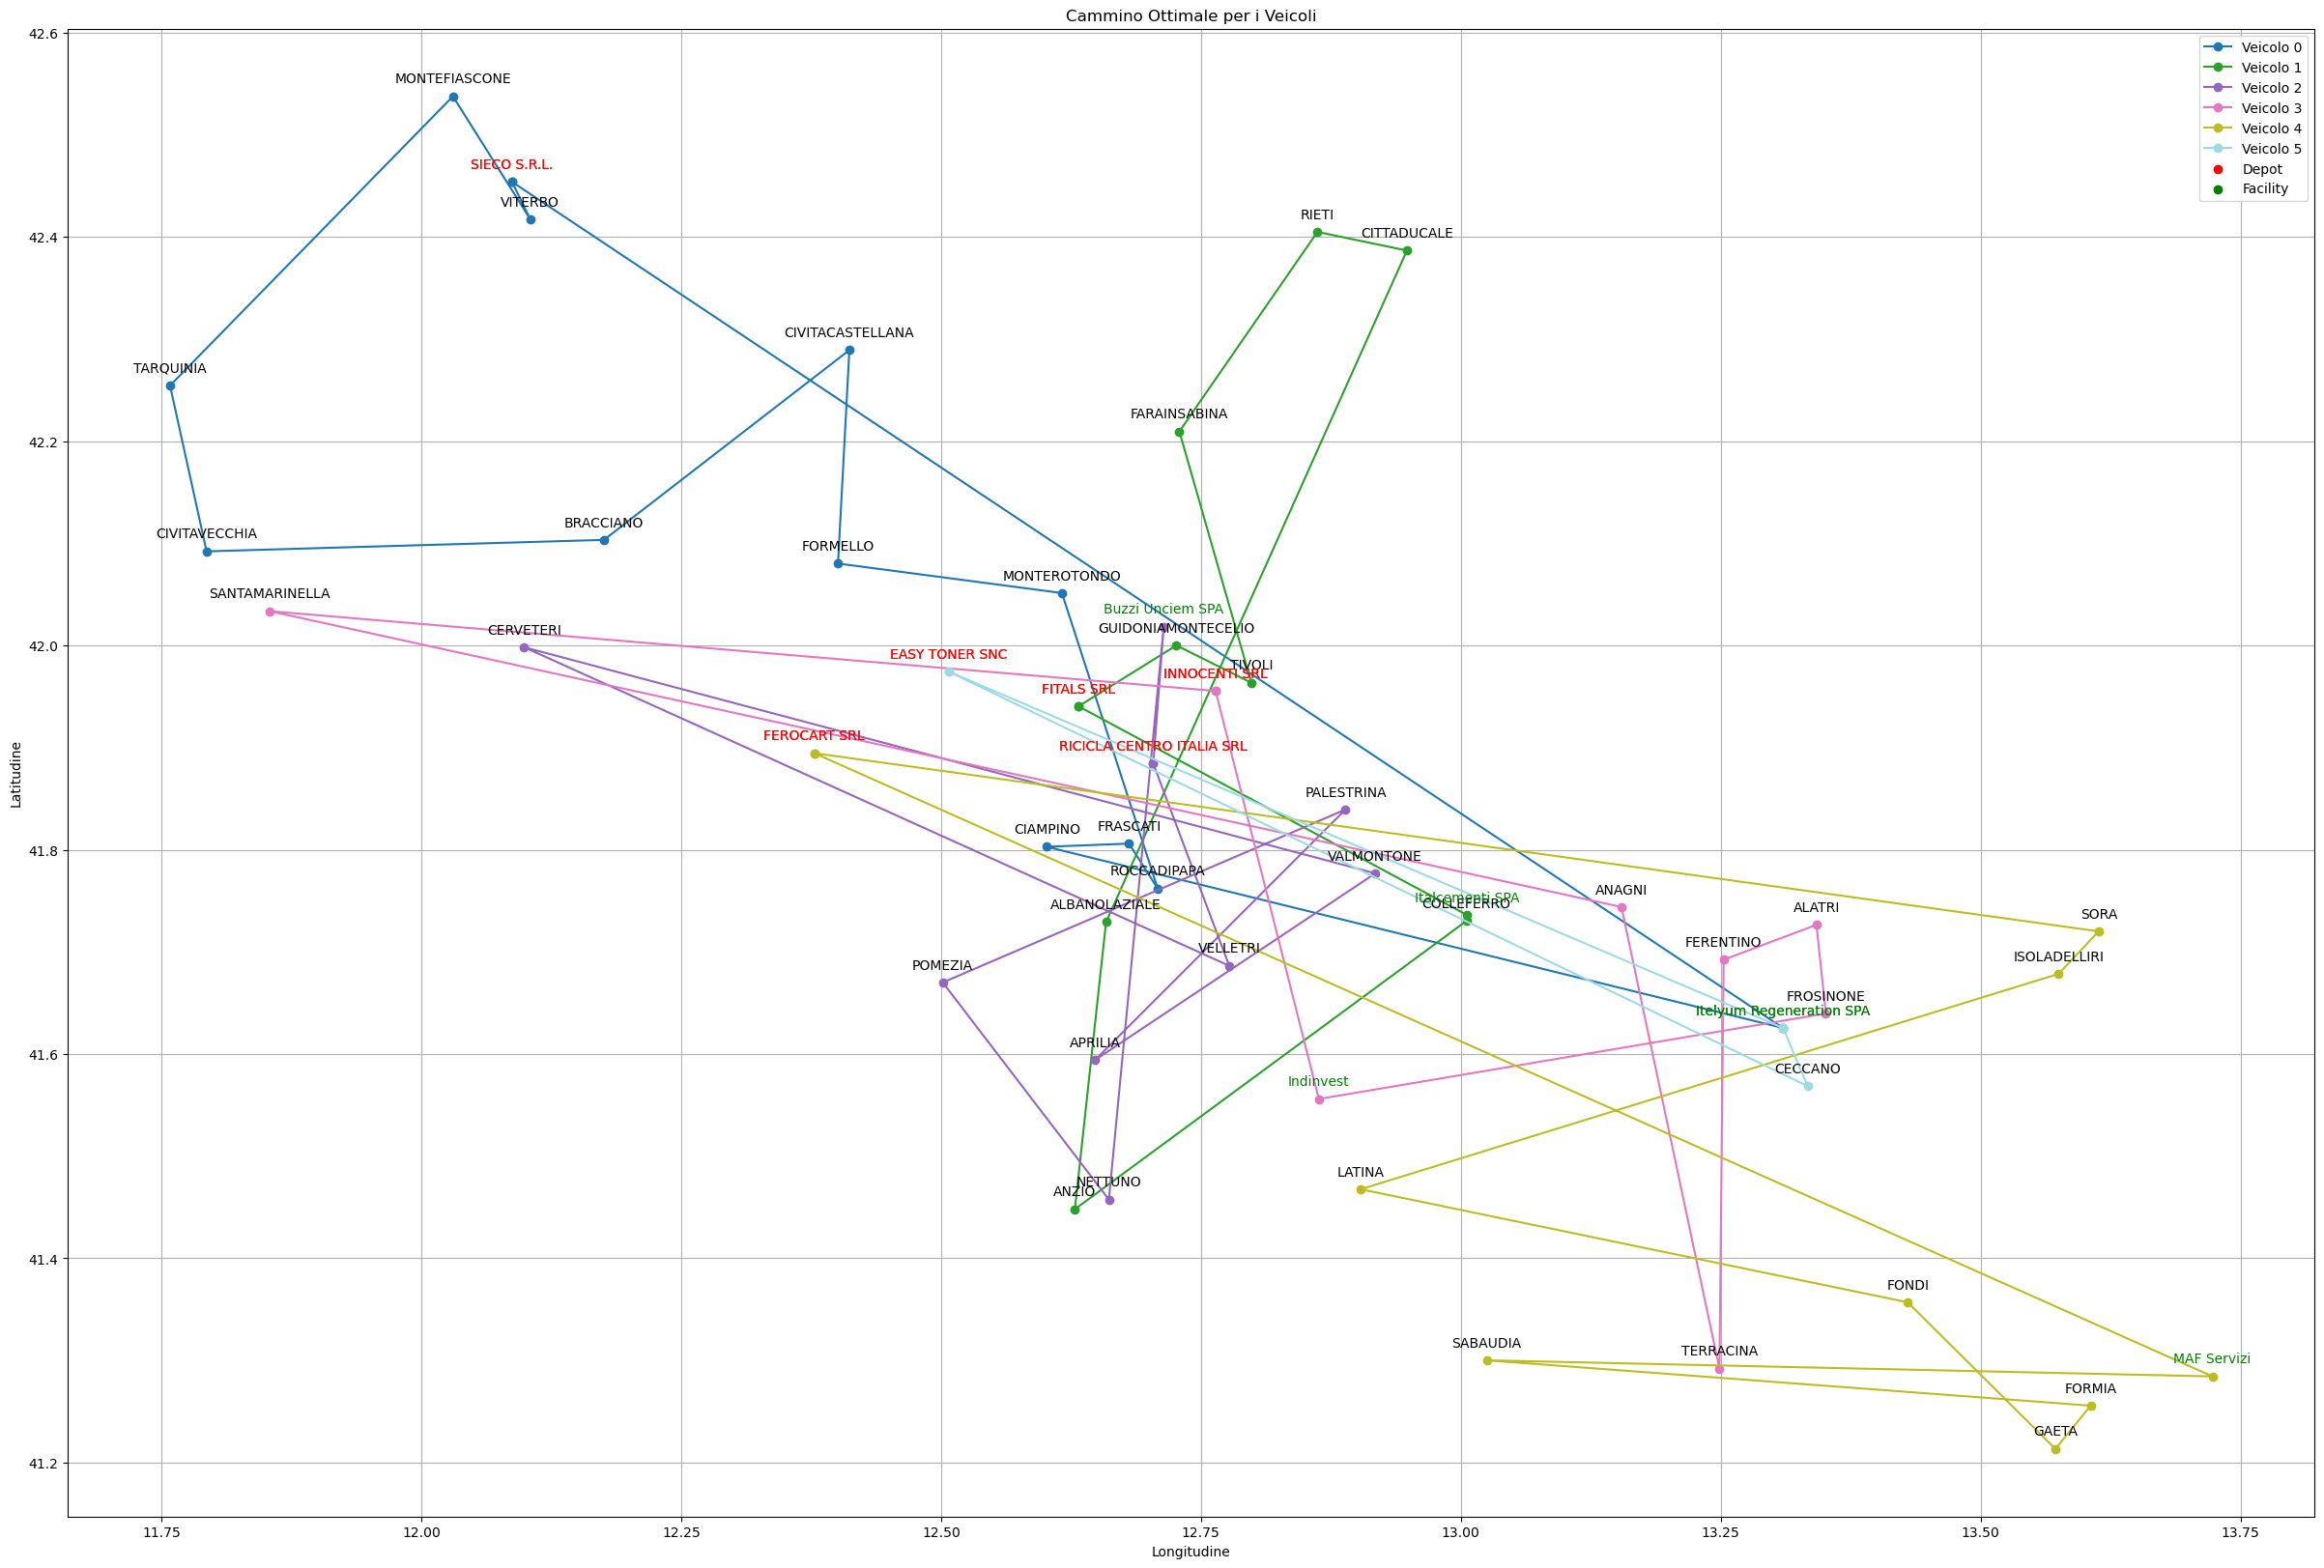

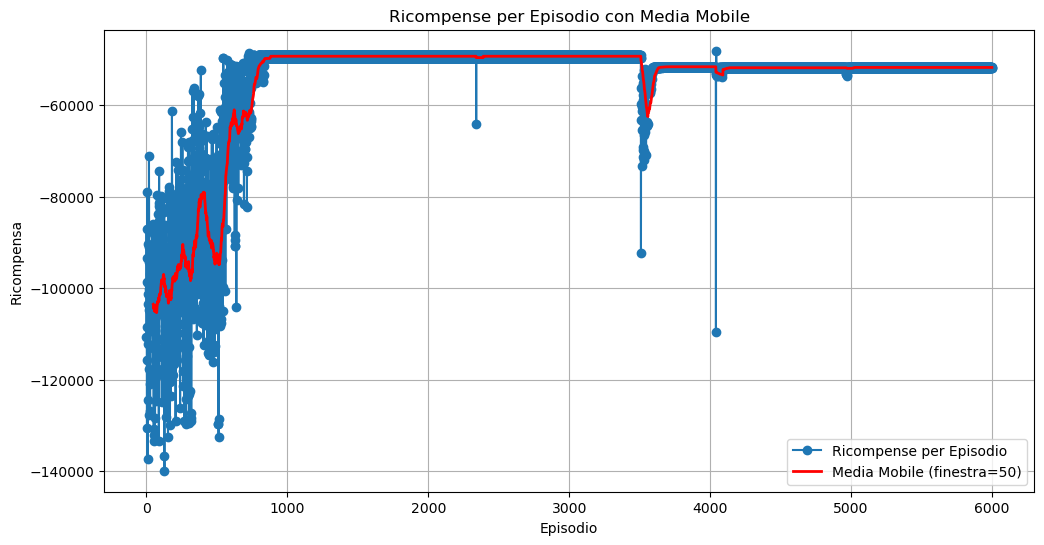

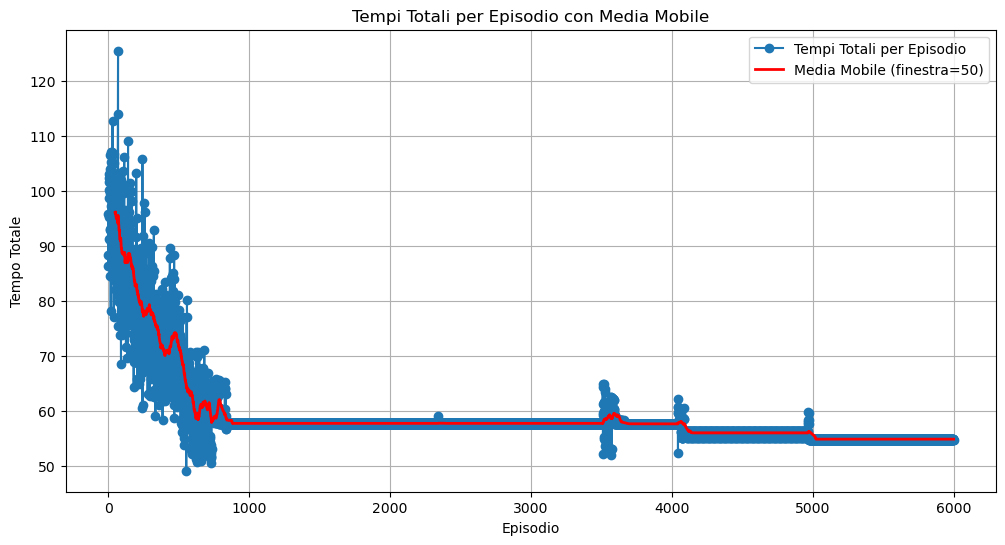

In [3]:
# Visualizzazione dell'ultimo cammino trovato
ql_vrp.plot_cammino(facility_names, ultimo_cammino)
ql_vrp.plot_rewards_per_episode(rewards_per_episode, window_size=50)
# Plottare i tempi totali per episodio
ql_vrp.plot_tempi_totali_per_episode(tempi_totali_per_episode)

# Estrazione delle variabili in formato JSON
variabili_json = ql_vrp.estrai_variabili_json(ultimo_cammino)

# salva il JSON
json_output = json.dumps(variabili_json, indent=4)

# Salva il JSON su un file
with open("formulazione/percorsi_formulazione.json", "w") as file:
    file.write(json_output)

In [14]:
print(tempi_totali_per_episode)

[95.9396, 88.4256, 86.4744, 103.2258, 102.4166, 95.23660000000001, 100.1942, 91.35900000000001, 98.7914, 101.60579999999999, 99.76500000000001, 84.6836, 93.02080000000001, 106.6488, 91.2818, 103.9664, 93.0872, 107.0546, 78.2852, 90.69919999999999, 104.07, 105.3302, 88.70960000000001, 97.3898, 101.18019999999999, 101.3754, 92.51759999999999, 104.7636, 107.0526, 84.664, 91.302, 112.8088, 99.9222, 102.22019999999999, 93.6754, 88.7088, 97.3004, 98.4434, 83.8304, 77.1486, 89.74239999999999, 101.0746, 106.81800000000001, 105.16059999999999, 84.8098, 99.6054, 91.185, 95.56479999999999, 93.2012, 93.46979999999999, 89.77199999999999, 90.6866, 97.6, 82.0422, 98.89460000000001, 82.3106, 95.2652, 91.0878, 82.01339999999999, 99.19579999999999, 98.76140000000001, 97.39099999999999, 89.285, 103.1362, 84.08539999999999, 90.16739999999999, 83.6548, 93.4736, 103.2564, 114.0236, 125.5538, 75.5178, 81.0892, 89.04, 83.2718, 79.9238, 80.0098, 88.28, 82.0022, 91.0778, 81.97040000000001, 73.8098, 75.5286, 92.

## epsilon decay 0,95

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import json

class TSPEnvironment:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities, depot_positions, distance_matrix, speed=50, max_time=8):
        self.num_nodi = len(facility_positions) + len(client_positions) + len(depot_positions)  # Consideriamo anche le facility come nodi
        self.nodes_positions = facility_positions + client_positions + depot_positions # Aggiungiamo le posizioni delle facility

        self.demands = np.array([0] * len(facility_positions) + demands + [0] * len(depot_positions))  # Aggiungiamo domanda zero per le facility
        self.facility_positions= facility_positions
        self.client_positions= client_positions
        self.depot_positions= depot_positions
        self.vehicle_capacities = np.array(vehicle_capacities)
        self.facility_capacities = np.array(facility_capacities)
        self.speed = speed  # Velocità in km/h
        self.max_time = max_time  # Tempo massimo in ore
        # Pre-calcola le distanze tra i nodi
        self.distance_matrix = distance_matrix.to_numpy()


    def calcola_distanza(self, node1, node2):
        return self.distance_matrix[node1][node2]


    def calcola_tempo(self, distanza_km):
        return distanza_km / self.speed

class QLearningVRP:
    def __init__(self, client_positions, demands, vehicle_capacities, facility_positions, facility_capacities, depot_positions, num_vehicles, distance_matrix, learning_rate=0.2, discount_factor=0.9, initial_epsilon=1.0, epsilon_decay=0.99, random_seed=0):
        np.random.seed(random_seed)
        random.seed(random_seed)
        self.env = TSPEnvironment(client_positions, demands, vehicle_capacities, facility_positions, facility_capacities, depot_positions,distance_matrix)
        self.num_nodi = len(facility_positions) + len(client_positions) + len(depot_positions)
        self.num_vehicles = num_vehicles
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.exploration_rate = initial_epsilon
        self.q_table = {}
        self.visitati = set()
        self.performance_history = []
        self.facility_visitata_dal_veicolo=[False]*num_vehicles

    def get_state_id(self, cammini):
        state_id = hash(tuple((idx, tuple(cammino)) for idx, cammino in enumerate(cammini))) #anche se i veicoli hanno percorsi uguali, avranno stati diversi.

        if state_id not in self.visitati:
            self.visitati.add(state_id)
            return state_id
        else:
            return None

    def aggiorna_q_table(self, state_id, action, reward, next_state_id):
        if state_id not in self.q_table: # se lo state_id è presente nella Q-table. Se non è presente, lo inizializza come un dizionario vuoto 
            self.q_table[state_id] = {}
        if action not in self.q_table[state_id]:# Verifica se l'action è presente nella Q-table per lo state_id. Se non è presente, inizializza il valore di Q per quell'azione a 0
            self.q_table[state_id][action] = 0

        if next_state_id in self.q_table: #Se next_state_id è presente nella Q-table, calcola td_target come la somma di reward e fattore di sconto moltiplicato per il valore Q dell'azione migliore (best_next_action) nello next_state_id.
            best_next_action = max(self.q_table[next_state_id], key=lambda a: self.q_table[next_state_id][a])
            td_target = reward + self.discount_factor * self.q_table[next_state_id][best_next_action]
        else:
            td_target = reward #Se next_state_id non è presente nella Q-table, imposta td_target uguale alla reward (poiché non c'è informazione sullo stato successivo)

        td_error = td_target - self.q_table[state_id][action] #Calcola l'errore TD come la differenza tra td_target e il valore Q attuale per lo state_id 
        self.q_table[state_id][action] += self.learning_rate * td_error #Aggiorna il valore Q per lo state_id e action utilizzando il learning rate



    def calcola_ricompensa(self, cammini, carico_facilities, domanda_rimanente, log=False):
        # Inizializzazione delle variabili
        tempo_totali = [0] * self.num_vehicles
        carichi = [0] * self.num_vehicles
        distanze_totali = []
    
        # Calcolo del tempo totale e del carico totale per ciascun veicolo
        for idx, cammino in enumerate(cammini):
            for i in range(len(cammino) - 1):
                distanza = self.env.calcola_distanza(cammino[i], cammino[i + 1])
                tempo_totali[idx] += self.env.calcola_tempo(distanza)
                carichi[idx] += self.env.demands[cammino[i + 1]]
                distanze_totali.append(distanza)
    
        # Calcolo della ricompensa basata sul tempo per ogni singolo veicolo
        ricompensa_tempo = 0
        for tempo in tempo_totali:
            ricompensa_veicolo_tempo = -tempo
            if tempo > self.env.max_time:
                ricompensa_veicolo_tempo -= 100 * (tempo - self.env.max_time)
            ricompensa_tempo += ricompensa_veicolo_tempo
    
        # Calcolo della ricompensa basata sul carico per ogni singolo veicolo
        ricompensa_carico = 0
        for carico in carichi:
            ricompensa_veicolo_carico = -carico
            max_vehicle_capacity = np.max(self.env.vehicle_capacities)
            if carico > max_vehicle_capacity:
                ricompensa_veicolo_carico -= 100 * (carico - max_vehicle_capacity)
            ricompensa_carico += ricompensa_veicolo_carico
    
        # Calcolo unfairness
        max_diff = 0
        for i in range(len(distanze_totali)):
            for j in range(i + 1, len(distanze_totali)):
                diff = abs(distanze_totali[i] - distanze_totali[j])
                if diff > max_diff:
                    max_diff = diff
    
        unfairness = -10 * max_diff
    
        # Calcolo della ricompensa basata sui carichi delle strutture per ogni singola facility
        ricompensa_facilities = 0
        for i in range(len(carico_facilities)):
            ricompensa_facility = 0
            if carico_facilities[i] > self.env.facility_capacities[i]:
                ricompensa_facility -= 100 * (carico_facilities[i] - self.env.facility_capacities[i])
            ricompensa_facilities += ricompensa_facility
    
        # Calcolo della ricompensa totale combinando le diverse componenti
        total_reward = (ricompensa_tempo +
                        ricompensa_carico +
                        ricompensa_facilities +
                        unfairness)
    
        # Stampa dei dettagli della ricompensa se log è True
        if log:
            print(f"Reward Componenti:\n"
                  f"Tempo: {ricompensa_tempo}\n"
                  f"Carico: {ricompensa_carico}\n"
                  f"Facilities: {ricompensa_facilities}\n"
                  f"Unfairness: {unfairness}\n"
                  f"Total Reward: {total_reward}\n")
    
        return total_reward



    #ottimizza tra esplorazione e sfruttamento in modo adattivo basandosi sulle performance recenti dell'algoritmo.
    def aggiorna_epsilon_adattivo(self, soglia_performance=0.2):
        if len(self.performance_history) > 10: # Calcola la media delle differenze tra le performance delle ultime 10 iterazioni.
            # miglioramento_medio = np.mean(np.diff(self.performance_history[-10:]))
            # if miglioramento_medio < soglia_performance:
            #     self.exploration_rate = min(self.exploration_rate * 1.01, 1.0)#Se il miglioramento medio è inferiore alla soglia (soglia_performance), aumenta il tasso di esplorazione del 1%.
            # else:
            self.exploration_rate = max(self.exploration_rate * 0.95, 0.001) #Se il miglioramento medio è maggiore o uguale alla soglia, riduce il tasso di esplorazione del 5% (fino a un minimo di 0.00001).




    def addestramento(self, num_episodi):
        global nodo_successivo
        rewards_history = []
        rewards_cumulative = []
        ultimo_cammino = None
        rewards_per_episode = []
        tempi_totali_per_episode = [] 
        depot_positions_indices = list(range(self.num_nodi - len(self.env.depot_positions), self.num_nodi))
        #print(depot_positions_indices)
        
        for episode in range(num_episodi):
            start_nodes = depot_positions_indices   # Lista dei nodi deposito
            cammini = []
            nodi_correnti = []
            domanda_rimanente = self.env.demands.copy()  #per il Tracciamento delle domande rimanenti           
            carico_corrente = [0] * self.num_vehicles
            carico_facilities = [0] * len(self.env.facility_positions)
            total_reward = 0
            facility_visitata_dal_veicolo = [False] * self.num_vehicles #per capire se il veicolo ha già visitato la facility
            vehicle_active = [True] * self.num_vehicles
            nodo_visitato_dal_veicolo = [False] * self.num_vehicles
            clienti_da_visitare = set(range(self.num_nodi -len(self.env.depot_positions)-len(self.env.client_positions),self.num_nodi -len(self.env.depot_positions)))

            # Inizializza i cammini, nodi correnti e assegnazioni dei depositi
            for idx in range(self.num_vehicles):
                start_node = start_nodes[idx % len(start_nodes)]
                cammini.append([start_node])
                nodi_correnti.append(start_node)



            while len(clienti_da_visitare)>=0: 

                nonvisitati = [node for node in range(self.num_nodi) if node not in start_nodes]
                valid_action = False

                for idx, cammino in enumerate(cammini):

                    if len(clienti_da_visitare) == 0:
                        # Solo facilities possono essere scelte se tutti i clienti sono stati visitati
                        facilities_non_visitati = [node for node in nonvisitati if  node < self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions)]
                        facilities_non_visitati_cs = [
                        node for node in facilities_non_visitati 
                        if carico_corrente[idx] <= self.env.facility_capacities[node - (self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))] - carico_facilities[node - (self.num_nodi - len(self.env.client_positions) - len(self.env.depot_positions))]
                    ]
                        

                        if facilities_non_visitati_cs:# se ci sono facilities (con sufficiente capacità) visitabili allora scegli tra quelle

                            if nodo_visitato_dal_veicolo[idx]:# Controlla se il veicolo ha visitato almeno un nodo cliente dopo il deposito
                                nodo_successivo = np.random.choice(facilities_non_visitati_cs) if np.random.rand() < self.exploration_rate else facilities_non_visitati_cs[np.argmax([self.q_table.get(self.get_state_id([cammino + [action] for cammino in cammini if vehicle_active[idx]]), {}).get(action, 0) for action in facilities_non_visitati_cs])]

                            else:

                                continue  # Se il veicolo ha solo il deposito nel cammino, non scegli nessun nodo_successivo
                        else:#le facilities non hanno le capacità sufficienti allora scegline una che non ha la capacità sufficiente
                            facilities_non_visitati_ns = [node for node in nonvisitati if  node < self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions)]
                            if facilities_non_visitati_ns:
                                # Controlla se il veicolo ha visitato almeno un nodo cliente dopo il deposito
                                if nodo_visitato_dal_veicolo[idx]:
                                    nodo_successivo = np.random.choice(facilities_non_visitati_ns) if np.random.rand() < self.exploration_rate else facilities_non_visitati_ns[np.argmax([self.q_table.get(self.get_state_id([cammino + [action] for cammino in cammini if vehicle_active[idx]]), {}).get(action, 0) for action in facilities_non_visitati_ns])]

                                else:
    
                                    continue  # Se il veicolo ha solo il deposito nel cammino, non scegli nessun nodo_successivo                            
                            
                        # print(f"{len(clienti_da_visitare)},Episode {episode+1}, Vehicle {idx}, Nodo successivo: {nodo_successivo}, Tipo: Facility")                        
                    else: #se ci sono ancora clienti da visitare scegli solo tra i nodi cliente per cui il tempo non superi quello max (8 ore)
                        clienti_non_visitati = [node for node in nonvisitati if node in clienti_da_visitare] 
    
                        # Calcolo del tempo totale attuale per il veicolo
                        tempo_attuale = sum(self.env.calcola_tempo(self.env.calcola_distanza(cammino[i], cammino[i + 1])) for i in range(len(cammino) - 1))
    
                        # Filtra i clienti non visitati in base al tempo massimo consentito
                        clienti_validi = [cliente for cliente in clienti_non_visitati if tempo_attuale + self.env.calcola_tempo(self.env.calcola_distanza(nodi_correnti[idx], cliente)) <= self.env.max_time]
                        
                        if not clienti_validi:
                            continue
                        
                        if np.random.rand() < self.exploration_rate:
                            nodo_successivo = np.random.choice(clienti_validi)
                        else:
                            q_values = [self.q_table.get(self.get_state_id([cammino + [action] for cammino in cammini if vehicle_active[idx]]), {}).get(action, 0) for action in clienti_validi]
                            nodo_successivo = clienti_validi[np.argmax(q_values)]
                           
                        # print(f"{len(clienti_da_visitare)},Episode {episode+1}, Vehicle {idx}, Nodo successivo: {nodo_successivo}, Tipo: Cliente")   
                    
                        
                    if not vehicle_active[idx]:
                        continue


                    if carico_corrente[idx] + domanda_rimanente[nodo_successivo] <= self.env.vehicle_capacities[idx]:
                        #print(carico_corrente[idx] + domanda_rimanente[nodo_successivo] <= self.env.vehicle_capacities[idx])
                        if nodo_successivo < self.num_nodi - len(self.env.depot_positions) - len(self.env.client_positions) :  # Facility
                            #print(nodo_successivo)
                            facility_idx = nodo_successivo - (self.num_nodi - len(self.env.client_positions)- len(self.env.depot_positions))
                            
                            if not facility_visitata_dal_veicolo[idx]: # Veicolo non ha ancora visitato una facility e ha visitato almeno un nodo
                                # print(f"facility")
                                #print(f"Veicolo {idx} ha aggiunto la facility {nodo_successivo} al proprio cammino.")
                                facility_visitata_dal_veicolo[idx] = True
                                cammino.append(nodo_successivo)
                                carico_facilities[facility_idx] += carico_corrente[idx]
                                nodi_correnti[idx] = nodo_successivo
                                reward = self.calcola_ricompensa(cammini, carico_facilities, domanda_rimanente)
                                carico_corrente[idx] = 0
                                vehicle_active[idx]= False
                                valid_action = True
                                nonvisitati.remove(nodo_successivo)
                                if self.env.facility_capacities[facility_idx]- carico_facilities[facility_idx]>0:
                                    #print(self.env.facility_capacities[facility_idx]- carico_facilities[facility_idx])
                                    nonvisitati.append(nodo_successivo)
                                break


                        elif nodo_successivo in clienti_da_visitare:
                            
                            cammino.append(nodo_successivo)
                            carico_corrente[idx] += domanda_rimanente[nodo_successivo]
                            domanda_rimanente[nodo_successivo] = 0
                            nodi_correnti[idx] = nodo_successivo
                            reward = self.calcola_ricompensa(cammini, carico_facilities, domanda_rimanente)
                            valid_action = True
                            nodo_visitato_dal_veicolo[idx] = True  # indica se il veicolo ha visitato almeno un nodo
                            vehicle_active[idx]= True
                            nonvisitati.remove(nodo_successivo)
                            clienti_da_visitare.remove(nodo_successivo)
                            break



                if not valid_action:

                    #reward = -100


                    break



                total_reward += reward
                state_id = self.get_state_id(cammini[:-1])
                next_state_id = self.get_state_id(cammini)

                self.aggiorna_q_table(state_id, nodo_successivo, reward, next_state_id)

            # I veicoli ritornano ai rispettivi depositi
            for idx in range(self.num_vehicles):
                 # solo per i veicoli che non hanno visitato la facility
                start_node = start_nodes[idx % len(start_nodes)]
                cammini[idx].append(start_node)  # Utilizza il nodo deposito corretto per ogni veicolo

            # Calcola la ricompensa finale e aggiungi il valore al reward totale
            ricompensa_finale = self.calcola_ricompensa(cammini, carico_facilities, domanda_rimanente)
            total_reward += ricompensa_finale
            rewards_history.append(total_reward)
            rewards_cumulative.append(np.sum(rewards_history))
            rewards_per_episode.append(total_reward)
            # Calcolo dei tempi totali per ogni veicolo in questo episodio
            tempi_totali = [0] * self.num_vehicles  # Inizializzazione della lista dei tempi totali per ogni veicolo
            for idx, cammino in enumerate(cammini):
                for i in range(len(cammino) - 1):
                    distanza = self.env.calcola_distanza(cammino[i], cammino[i + 1])
                    tempi_totali[idx] += self.env.calcola_tempo(distanza)
            
            # Somma dei tempi totali per tutti i veicoli in questo episodio
            
            tempi_totali_per_episode.append(np.sum(tempi_totali))
            
            # Aggiorna il valore di epsilon usando la strategia epsilon greedy adattiva
            self.performance_history.append(total_reward)
            self.aggiorna_epsilon_adattivo()

            if (episode + 1) % 10 == 0:
                print(f'Episodio: {episode + 1}, Reward: {total_reward}, Epsilon: {self.exploration_rate}')
                ultimo_cammino = cammini
            # Stampa le capacità delle facilities alla fine di ogni episodio
            if (episode + 1) == num_episodi:
                print("\nCapacità delle facilities:")
                for idx, capacity in enumerate(self.env.facility_capacities):
                    current_load = carico_facilities[idx]
                    print(f"Facility {idx + 1}: Capacità={capacity}, Carico attuale={current_load}\n")
                    
                print("\nPercorso dei veicoli:")
                for idx, cammino in enumerate(ultimo_cammino):
                    print(f"Veicolo {idx}: {cammino}")                    

        return rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode,tempi_totali_per_episode




    def plot_cammino(self, node_names, cammini, start_label="depot", end_label="end", save_cammino=None):
        plt.figure(figsize=(30, 20))
        nodes_positions = self.env.nodes_positions

        # Filtra i cammini validi (cammini con più di un nodo)
        cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
        print(cammini_validi)
        num_veicoli_utilizzati = len(cammini_validi)
        #print(num_veicoli_utilizzati)

        # Colormap per veicoli utilizzati
        colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)


        # Plot solo i veicoli utilizzati
        for idx, cammino in enumerate(cammini_validi):
            coords = [nodes_positions[node] for node in cammino]
            xs, ys = zip(*coords)
            plt.plot(ys, xs, marker='o', color=colors(idx), label=f'Veicolo {idx}')
            for i, node in enumerate(cammino):
                if node in range(len(nodes_positions) - len(self.env.depot_positions), len(nodes_positions)): #depot
                    label_color = 'red'
                    label = node_names[node]
                elif node in range(len(nodes_positions) - len(self.env.client_positions) - len(self.env.depot_positions)):
                    label_color = 'green'
                    label = node_names[node]
                else:
                    label_color = 'black'
                    label = node_names[node] if node < len(node_names) else f'Node {node+1}'
                plt.annotate(label, (ys[i], xs[i]), textcoords="offset points", xytext=(0, 10), ha='center', color=label_color)

        # Aggiungi marker per facility e depot
        plt.scatter([], [], c='red', marker='o', label='Depot')
        plt.scatter([], [], c='green', marker='o', label='Facility')

        plt.xlabel('Longitudine')
        plt.ylabel('Latitudine')
        plt.title('Cammino Ottimale per i Veicoli')
        plt.grid(True)
        plt.legend()  # Aggiunge la legenda
        if save_cammino:
            plt.savefig(save_cammino)
        plt.show()


    def plot_rewards_per_episode(self, rewards_per_episode, window_size=50):
        # Calcola la media mobile
        moving_avg_rewards = np.convolve(rewards_per_episode, np.ones(window_size) / window_size, mode='valid')
    
        plt.figure(figsize=(12, 6))
        plt.plot(rewards_per_episode, marker='o', linestyle='-', label='Ricompense per Episodio')
        plt.plot(range(window_size - 1, len(rewards_per_episode)), moving_avg_rewards, color='r', linestyle='-', linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Ricompense per Episodio con Media Mobile')
        plt.xlabel('Episodio')
        plt.ylabel('Ricompensa')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_tempi_totali_per_episode(self, tempi_totali_per_episode, window_size=50):
        moving_avg_tempi = np.convolve(tempi_totali_per_episode, np.ones(window_size) / window_size, mode='valid')
    
        plt.figure(figsize=(12, 6))
        plt.plot(tempi_totali_per_episode, marker='o', linestyle='-', label='Tempi Totali per Episodio')
        plt.plot(range(window_size - 1, len(tempi_totali_per_episode)), moving_avg_tempi, color='r', linestyle='-', linewidth=2, label='Media Mobile (finestra={})'.format(window_size))
        plt.title('Tempi Totali per Episodio con Media Mobile')
        plt.xlabel('Episodio')
        plt.ylabel('Tempo Totale')
        plt.legend()
        plt.grid(True)
        plt.show()

    def stampa_dimensioni_q_table(self):
        num_stati = len(self.q_table)
        if num_stati == 0:
            num_azioni = 0
        else:
            num_azioni = max(len(self.q_table[state]) for state in self.q_table)

        print(f"Dimensione finale della Q-table: {num_stati} righe (stati) x {num_azioni} colonne (azioni)")
    
    def estrai_variabili_json(self, cammini):
         h = dict()
         z = dict()
    
         # Inizializza tutte le variabili h a 0
         for veicolo in range(self.num_vehicles):
              for nodo in range(self.num_nodi):
                   h[f"({veicolo}, {nodo})"] = 0.0
    
         # Inizializza tutte le variabili z a 0
         for veicolo in range(self.num_vehicles):
              for nodo_corrente in range(self.num_nodi):
                   for nodo_successivo in range(self.num_nodi):
                        z[f"({veicolo}, {nodo_corrente}, {nodo_successivo})"] = 0.0
        
         cammini_validi = [cammino for cammino in cammini if len(cammino) > 2]
         for veicolo, cammino in enumerate(cammini_validi):
              # Aggiungi le variabili h
              for nodo in cammino:
                   h[f"({veicolo}, {nodo})"] = 1.0
    
              # Aggiungi le variabili z
              for i in range(len(cammino) - 1):
                   nodo_corrente = cammino[i]
                   nodo_successivo = cammino[i + 1]
                   z[f"({veicolo}, {nodo_corrente}, {nodo_successivo})"] = 1.0
    
         return {"h": h, "z": z}



In [9]:
file_path = 'data/output - Copia.xlsx'
dfnodi = pd.read_excel(file_path, sheet_name="nodi")
matrice_distanze=pd.read_csv('data/distance_matrix-orig.csv', index_col=0)

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
lat = dfnodi['lat']
long = dfnodi['long']
node_names = dfnodi[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
nodes_posizioni = [[lat[i], long[i]] for i in range(len(dfnodi))]
print(len(nodes_posizioni))

# Crea un array per le domande dei nodi
demands = dfnodi["demand_daily"].tolist()


#depot
file_path = 'data/output - Copia.xlsx'
dfdepot = pd.read_excel(file_path, sheet_name= "depot")
latdepot = dfdepot['lat']
longdepot = dfdepot['long']
depot_names = dfdepot[node_name_column]
# Crea un array bidimensionale di posizioni dei nodi

depot_posizioni = [[latdepot[i], longdepot[i]] for i in range(len(dfdepot))]
print(len(depot_posizioni))

# Carica il file Excel delle strutture
file_path = 'data/output - Copia.xlsx'
dffacility = pd.read_excel(file_path, sheet_name="facility")

# Le colonne di latitudine e longitudine 'lat' e 'long'
node_name_column = 'node_name'

# Estrai i dati di latitudine, longitudine e nome del nodo
latf = dffacility['lat']
longf = dffacility['long']
facility_names = dffacility[node_name_column]

# Crea un array bidimensionale di posizioni dei nodi
facility_posizioni = [[latf[i], longf[i]] for i in range(len(dffacility))]
print(len(facility_posizioni))

# Crea un array per le domande dei nodi
facility_capacities = dffacility["facility_capacity"].tolist()

# Converti node_names in una lista e poi estendila
node_names = node_names.tolist()
facility_names = facility_names.tolist()
depot_names= depot_names.tolist()
facility_names.extend(node_names)
facility_names.extend(depot_names)
#
num_veicoli = 60
vehicle_capacities = [40] * num_veicoli

# Creazione dell'agente di Q-learning
ql_vrp = QLearningVRP(nodes_posizioni, demands, vehicle_capacities, facility_posizioni, facility_capacities, depot_posizioni, num_veicoli, matrice_distanze)

# Addestramento dell'agente

rewards_history, rewards_cumulative, ultimo_cammino, rewards_per_episode,tempi_totali_per_episode = ql_vrp.addestramento(num_episodi=5000)



40
10
10
Episodio: 10, Reward: -98842.01018904112, Epsilon: 1.0
Episodio: 20, Reward: -111146.31736712332, Epsilon: 0.5987369392383786
Episodio: 30, Reward: -89139.68740547943, Epsilon: 0.35848592240854177
Episodio: 40, Reward: -85392.06882465753, Epsilon: 0.2146387639429372
Episodio: 50, Reward: -94165.98836438355, Epsilon: 0.1285121565651031
Episodio: 60, Reward: -76737.00910958904, Epsilon: 0.07694497527671314
Episodio: 70, Reward: -82825.01113972602, Epsilon: 0.04606979898695193
Episodio: 80, Reward: -80459.1774191781, Epsilon: 0.027583690436774957
Episodio: 90, Reward: -68393.23883013698, Epsilon: 0.016515374385013576
Episodio: 100, Reward: -79614.37381917806, Epsilon: 0.009888364709658948
Episodio: 110, Reward: -79837.23683561642, Epsilon: 0.005920529220333997
Episodio: 120, Reward: -106665.53959726027, Epsilon: 0.0035448395440541612
Episodio: 130, Reward: -124617.43523835615, Epsilon: 0.002122426378698158
Episodio: 140, Reward: -70685.49932876714, Epsilon: 0.0012707750737405309


[[50, 46, 42, 49, 41, 15, 31, 33, 8, 50], [51, 18, 34, 38, 14, 30, 28, 43, 44, 9, 51], [52, 35, 29, 45, 13, 37, 36, 32, 47, 48, 2, 52], [53, 39, 27, 17, 11, 16, 23, 20, 5, 53], [54, 25, 40, 24, 26, 8, 54], [55, 10, 12, 22, 21, 19, 7, 55]]


C:\Users\eleon\AppData\Local\Temp\ipykernel_7364\1745217348.py:358: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_veicoli_utilizzati)


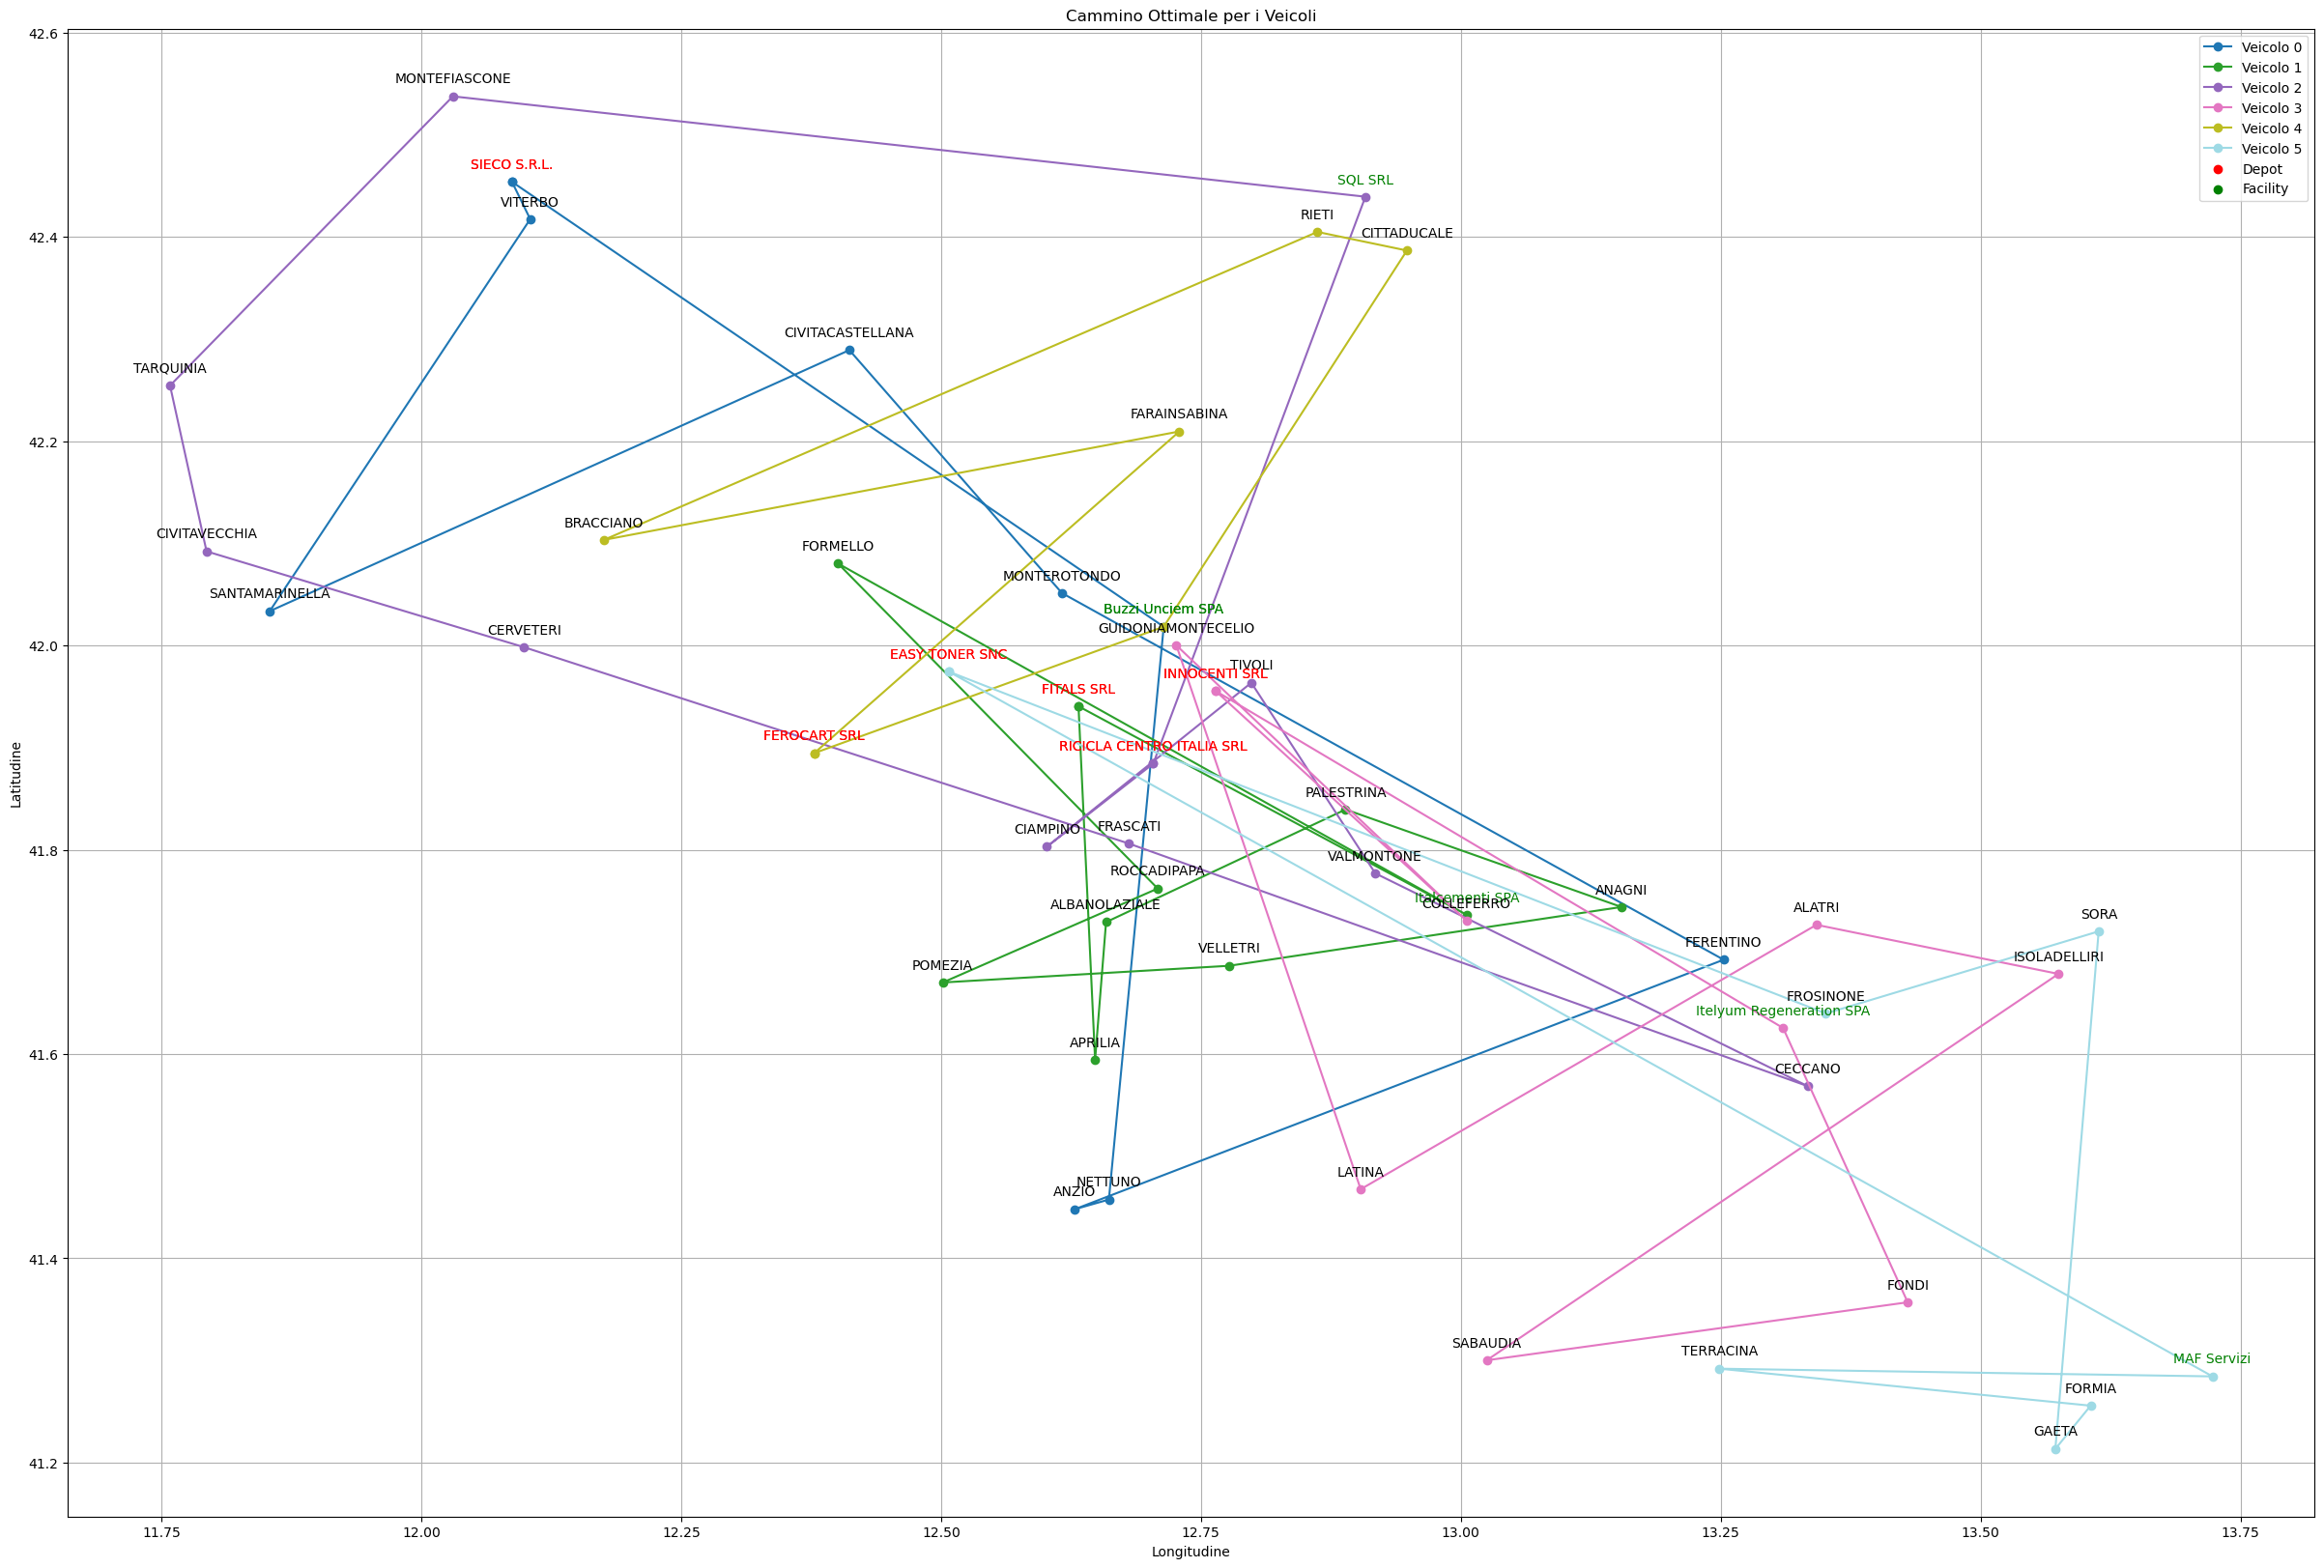

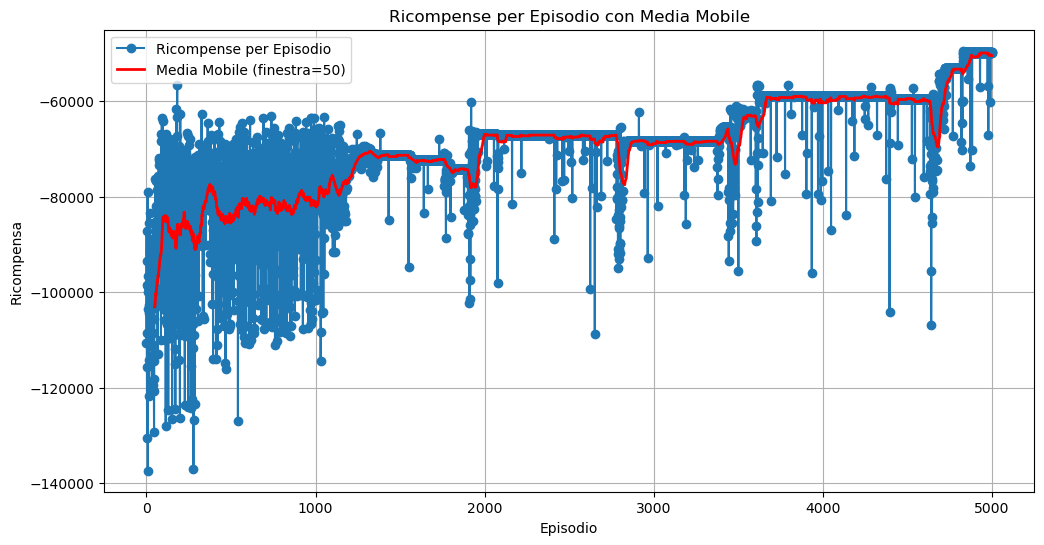

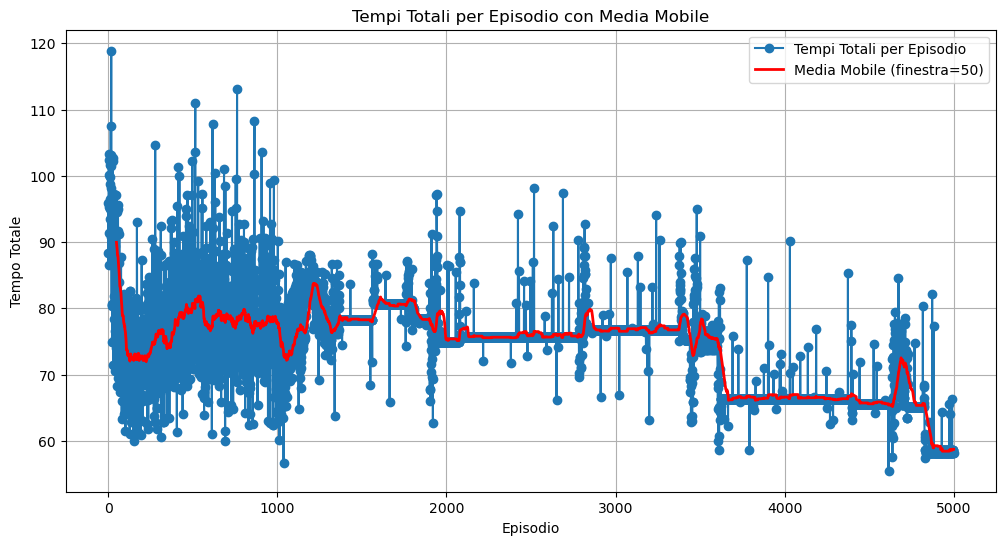

In [10]:
# Visualizzazione dell'ultimo cammino trovato
ql_vrp.plot_cammino(facility_names, ultimo_cammino)
ql_vrp.plot_rewards_per_episode(rewards_per_episode, window_size=50)
# Plottare i tempi totali per episodio
ql_vrp.plot_tempi_totali_per_episode(tempi_totali_per_episode)

# Estrazione delle variabili in formato JSON
variabili_json = ql_vrp.estrai_variabili_json(ultimo_cammino)

# salva il JSON
json_output = json.dumps(variabili_json, indent=4)

# Salva il JSON su un file
with open("formulazione/percorsi_formulazione-epsilon=0.95.json", "w") as file:
    file.write(json_output)

In [11]:
print(tempi_totali_per_episode)

[95.9396, 88.4256, 86.4744, 103.2258, 102.4166, 95.23660000000001, 100.1942, 91.35900000000001, 98.7914, 101.60579999999999, 99.76500000000001, 96.4384, 94.9234, 93.44279999999999, 90.7782, 107.46699999999998, 98.2212, 103.1034, 118.88660000000002, 101.55020000000002, 80.54660000000001, 80.4194, 88.875, 80.676, 89.9184, 74.92020000000001, 102.7284, 102.1746, 93.7402, 87.7894, 71.4494, 92.17500000000001, 97.20100000000001, 88.22659999999999, 81.84400000000001, 78.343, 80.6294, 74.958, 75.55439999999999, 76.56, 89.4406, 86.4952, 94.4812, 70.5252, 84.7674, 81.94059999999999, 77.3458, 74.01559999999999, 75.0162, 97.1408, 79.077, 82.218, 68.2894, 94.52340000000001, 76.1392, 76.73579999999998, 94.9688, 91.7028, 95.61540000000001, 80.033, 69.5434, 79.7332, 83.967, 80.87859999999999, 74.6442, 86.9134, 91.1684, 67.32799999999999, 80.4602, 81.87979999999999, 80.4674, 76.86760000000001, 71.5018, 74.0406, 77.6656, 71.5406, 87.7108, 72.726, 76.3818, 71.2596, 63.334, 68.5798, 66.06299999999999, 70.9